# Proyecto Final - IA

## Integrantes:
- **Roberto Vallecillos**
- **Alejandro Gómez**
- **María Isabel Solano**

In [30]:
# Librerias
import numpy as np
import pandas as pd
import seaborn as sns
import torchaudio
import os
import librosa
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from pprint import pprint
import matplotlib.pyplot as plt


### Se lee la metadata del archivo

In [2]:
metadata_file = 'instrumentos.csv'
metadata = pd.read_csv(metadata_file)


### Análisis de la metadata 

In [3]:
metadata.head()

,Path,Fold,Family,Instrument (abbr.),Instrument (in full),Technique (abbr.),Technique (in full),Pitch,Pitch ID,Dynamics,Dynamics ID,Instance ID,String ID (if applicable),Needed digital retuning
0,Brass/Bass_Tuba/ordinario/BTb-ord-F#1-pp-N-N.wav,2,Brass,BTb,Bass Tuba,ord,ordinario,F#1,30,pp,0,0,NaN,False
1,Brass/Bass_Tuba/ordinario/BTb-ord-G1-pp-N-R100...,4,Brass,BTb,Bass Tuba,ord,ordinario,G1,31,pp,0,0,NaN,True
2,Brass/Bass_Tuba/ordinario/BTb-ord-G#1-pp-N-T16...,3,Brass,BTb,Bass Tuba,ord,ordinario,G#1,32,pp,0,0,NaN,True
3,Brass/Bass_Tuba/ordinario/BTb-ord-A1-pp-N-T23d...,2,Brass,BTb,Bass Tuba,ord,ordinario,A1,33,pp,0,0,NaN,True
4,Brass/Bass_Tuba/ordinario/BTb-ord-A#1-pp-N-N.wav,0,Brass,BTb,Bass Tuba,ord,ordinario,A#1,34,pp,0,0,NaN,False


In [4]:
metadata['Family'].value_counts()

Strings      1193
Keyboards     689
Winds         576
Brass         455
Name: Family, dtype: int64

### EDA

<AxesSubplot:xlabel='Family', ylabel='count'>

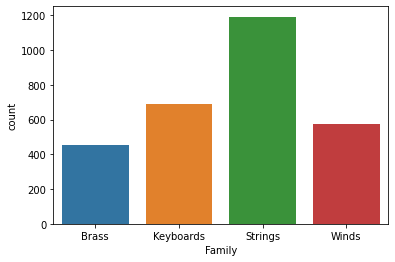

In [5]:
sns.countplot(x='Family', data=metadata)

<AxesSubplot:xlabel='Instrument (abbr.)', ylabel='Count'>

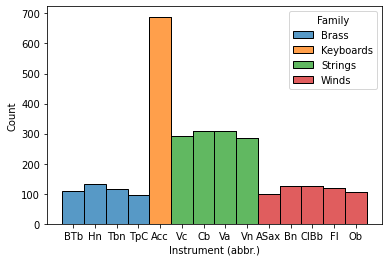

In [6]:
# Histograma:

sns.histplot(data=metadata, x="Instrument (abbr.)", hue="Family", multiple="stack")

<AxesSubplot:xlabel='Dynamics', ylabel='Count'>

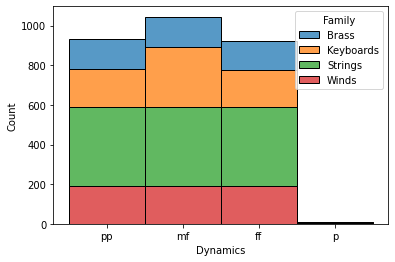

In [7]:
# Distribución de dinámicas:

sns.histplot(data=metadata, x="Dynamics", hue="Family", multiple="stack")

In [8]:
# Estadística descriptiva:

metadata.describe()

,Fold,Pitch ID,Dynamics ID,Instance ID,String ID (if applicable)
count,2913.000000,2913.000000,2913.000000,2913.000000,1193.000000
mean,2.000000,64.812908,1.988328,0.858565,2.432523
std,1.414699,16.874303,1.598592,1.124119,1.130280
min,0.000000,28.000000,0.000000,0.000000,1.000000
25%,1.000000,52.000000,0.000000,0.000000,1.000000
50%,2.000000,65.000000,2.000000,0.000000,2.000000
75%,3.000000,77.000000,4.000000,2.000000,3.000000
max,4.000000,109.000000,4.000000,5.000000,4.000000


/var/folders/vf/44lz8h455mvflsvv9khsdx5w0000gn/T/ipykernel_4288/1069144054.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(metadata.corr(), annot=True)


<AxesSubplot:>

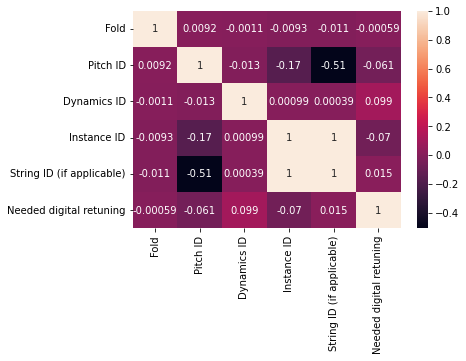

In [9]:
# Correlación:

sns.heatmap(metadata.corr(), annot=True)

<AxesSubplot:xlabel='count', ylabel='Instrument (in full)'>

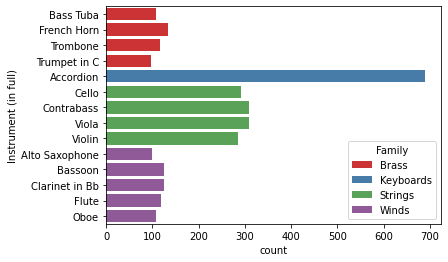

In [10]:

sns.countplot(y = "Instrument (in full)", hue = "Family", data = metadata, palette = "Set1" , dodge = False)


In [14]:
def featuresSeleccionar(file_path):
    audio, sample_rate = librosa.load(file_path, res_type='kaiser_fast')
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    return np.mean(mfccs.T, axis=0)

def DuracionAudio(file_path):
    audio, sample_rate = librosa.load(file_path, res_type='kaiser_fast')
    return librosa.get_duration(y=audio, sr=sample_rate)


In [15]:
features = []
labels = []
durations = []

for index, row in metadata.iterrows():
    file_path = os.path.join('Samples', row['Path'])
    features.append(featuresSeleccionar(file_path))
    labels.append(row['Instrument (in full)'])
    durations.append(DuracionAudio(file_path))

X = np.array(features)
y = np.array(labels)
durations = np.array(durations)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [18]:
svm = SVC(kernel='rbf', gamma='scale', C=1.0)
svm.fit(X_train_scaled, y_train)

SVC()

In [39]:
y_pred = svm.predict(X_test_scaled)

report_dict = classification_report(y_test, y_pred, output_dict=True)
del report_dict['accuracy']
del report_dict['macro avg']
del report_dict['weighted avg']

df = pd.DataFrame.from_dict(report_dict).T




Precision: 0.9239024721770741


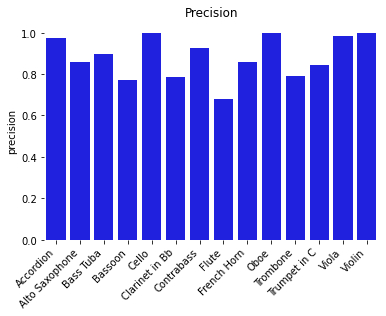

In [47]:
from sklearn.metrics import precision_score


sns.barplot(x=df.index, y=df['precision'], color='b')
sns.despine(left=True, bottom=True)
plt.xticks(rotation=45, ha='right')
plt.title('Precision')

print("Precision:", precision_score(y_test, y_pred, average='weighted'))

Recall: 0.9228130360205832


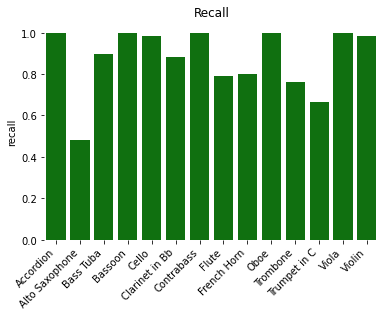

In [49]:
from sklearn.metrics import recall_score


sns.barplot(x=df.index, y=df['recall'], color='g')
sns.despine(left=True, bottom=True)
plt.xticks(rotation=45, ha='right')
plt.title('Recall')

print("Recall:", recall_score(y_test, y_pred, average='weighted'))

F1 Score:  0.9196836200441244


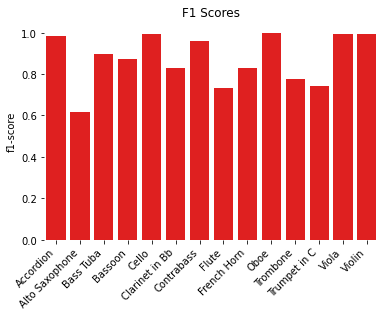

In [50]:
from sklearn.metrics import f1_score


sns.barplot(x=df.index, y=df['f1-score'], color='r')
sns.despine(left=True, bottom=True)
plt.xticks(rotation=45, ha='right')
plt.title('F1 Scores')

print("F1 Score: ", f1_score(y_test, y_pred, average='weighted'))

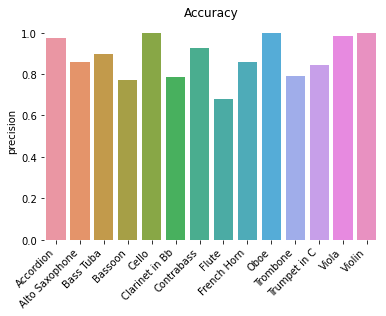

Accuracy: 0.9228130360205832


In [61]:
report = classification_report(y_test, y_pred, output_dict=True)
accuracy_df = pd.DataFrame.from_dict(report).transpose()
accuracy_df.drop(['accuracy', 'macro avg', 'weighted avg'], inplace=True)

sns.barplot(x=accuracy_df.index, y='precision', data=accuracy_df)
sns.despine(left=True, bottom=True)
plt.xticks(rotation=45, ha='right')
plt.title('Accuracy')
plt.show()

print(f"Accuracy: {report['accuracy']}")